# Creating AlchemicalNetworks from externally defined transformation networks

This notebook demonstrates how to load networks defined by FEP+ and Orion's NES planner for use within OpenFE.

## Some setup things

First we load our ligands from an SDF file `data/benzene_modifications.sdf`.

We also load in a protein `data/tyk2_protein.pdb` to demonstrate how we can eventually go about creating a full AlchemicalNetwork and write it to disk.

**Note:** the protein used is only for demonstration purposes, the ligands are not aligned in the binding site and therefore should not be direclty used for calculation purposes.

In [1]:
from rdkit import Chem
import openfe

/Users/atravitz/micromamba/envs/openfe_env/lib/python3.13/site-packages/openmoltools/utils.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_filename


In [2]:
# First we load in our ligands from an SDF file data/benzene_modifications.sdf

supplier = Chem.SDMolSupplier('data/benzene_modifications.sdf', removeHs=False)
smcs = [openfe.SmallMoleculeComponent(mol) for mol in supplier]

In [3]:
protein = openfe.ProteinComponent.from_pdb_file('data/tyk2_protein.pdb')

## Loading an FEP+ edges network

Here we show how to take an FEP+ edge network file, `data/benzenes.edge` and load it into an LigandNetwork object.

In [4]:
from openfe.setup.ligand_network_planning import load_fepplus_network

atom_mapper = openfe.LomapAtomMapper(max3d=1.0, element_change=False)

ligand_network = load_fepplus_network(
    ligands=smcs,
    mapper=atom_mapper,
    network_file='./data/benzenes.edge'
)

/Users/atravitz/software/gufe/gufe/components/explicitmoleculecomponent.py:74: UserWarning: RDKit does not preserve Mol properties when pickled by default, which may drop e.g. atom charges; consider setting `Chem.SetDefaultPickleProperties(Chem.PropertyPickleOptions.AllProps)`
  warnings.warn(
/Users/atravitz/software/gufe/gufe/components/explicitmoleculecomponent.py:74: UserWarning: RDKit does not preserve Mol properties when pickled by default, which may drop e.g. atom charges; consider setting `Chem.SetDefaultPickleProperties(Chem.PropertyPickleOptions.AllProps)`
  warnings.warn(


## Loading an Orion NES network file

Similarly we can take an Orion network edge file, `data/benzenes.dat` and load it into an LigandNetwork object.

In [5]:
from openfe.setup.ligand_network_planning import load_orion_network

atom_mapper = openfe.LomapAtomMapper(max3d=1.0, element_change=False)

ligand_network = load_orion_network(
    ligands=smcs,
    mapper=atom_mapper,
    network_file='./data/benzenes.dat'
)

/Users/atravitz/software/gufe/gufe/components/explicitmoleculecomponent.py:74: UserWarning: RDKit does not preserve Mol properties when pickled by default, which may drop e.g. atom charges; consider setting `Chem.SetDefaultPickleProperties(Chem.PropertyPickleOptions.AllProps)`
  warnings.warn(


## Visualizing the Network

Once defined we can visualise the network as we normally would.

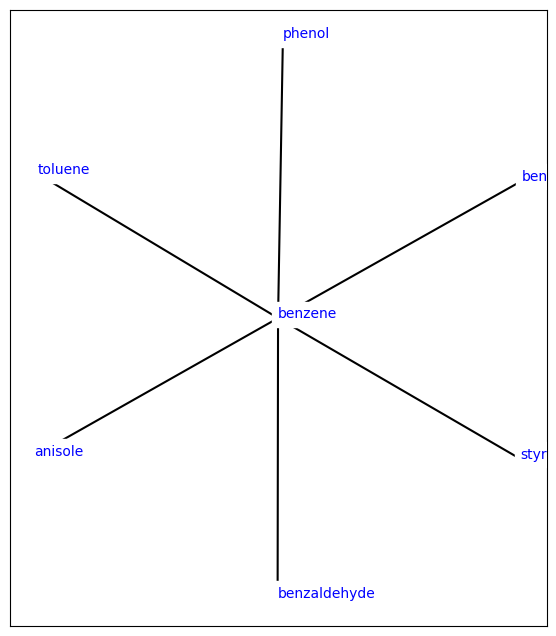

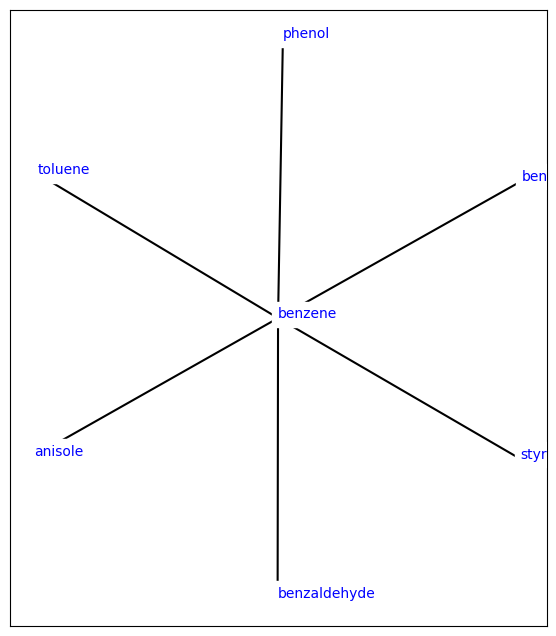

In [6]:
from openfe.utils.atommapping_network_plotting import plot_atommapping_network
plot_atommapping_network(ligand_network)

In [7]:
## Similarly we can visualize the invidual mappings

from ipywidgets import interact, widgets

def display_edge(index):
    view = edges[index].view_3d(spheres=True, show_atomIDs=True)
    view.show()

In [8]:
# traverse through all views

edges = list(ligand_network.edges)

interact(display_edge, index=widgets.IntSlider(min=0, max=len(edges)-1, step=1));

interactive(children=(IntSlider(value=0, description='index', max=5), Output()), _dom_classes=('widget-interac…

## Creating an AlchemicalNetwork

From one of these defined `ligand_network` objects, we can go ahead and create an AlchemicalNetwork which we can then execute using the OpenFE CLI.

In [9]:
## First let us define our simulation protocol

from openfe.protocols.openmm_rfe import RelativeHybridTopologyProtocol

# We can tweak the settings as necessary, for now we will stick to the defaults
settings = RelativeHybridTopologyProtocol.default_settings()
protocol = RelativeHybridTopologyProtocol(settings)

In [10]:
transformations = []

for mapping in ligand_network.edges:
    for leg in ['solvent', 'complex']:
        # use the solvent and protein created above
        sysA_dict = {'ligand': mapping.componentA,
                     'solvent': openfe.SolventComponent()}
        sysB_dict = {'ligand': mapping.componentB,
                     'solvent': openfe.SolventComponent()}
        
        if leg == 'complex':
            sysA_dict['protein'] = protein
            sysB_dict['protein'] = protein
        
        # we don't have to name objects, but it can make things (like filenames) more convenient
        sysA = openfe.ChemicalSystem(sysA_dict, name=f"{mapping.componentA.name}_{leg}")
        sysB = openfe.ChemicalSystem(sysB_dict, name=f"{mapping.componentB.name}_{leg}")
        
        prefix = "rbfe_"  # prefix is only to exactly reproduce CLI
        
        transformation = openfe.Transformation(
            stateA=sysA,
            stateB=sysB,
            mapping=mapping,
            protocol=protocol,  # use protocol created above
            name=f"{prefix}{sysA.name}_{sysB.name}"
        )
        transformations.append(transformation)

network = openfe.AlchemicalNetwork(transformations)

In [11]:
# Finally we write out the AlchemicalNetwork to disk

import pathlib
# first we create the directory
transformation_dir = pathlib.Path("transformations")
transformation_dir.mkdir(exist_ok=True)

# then we write out each transformation
for transformation in network.edges:
    transformation.to_json(transformation_dir / f"{transformation.name}.json")

In [18]:
!ls transformations

rbfe_benzene_complex_anisole_complex.json
rbfe_benzene_complex_benzaldehyde_complex.json
rbfe_benzene_complex_benzonitrile_complex.json
rbfe_benzene_complex_phenol_complex.json
rbfe_benzene_complex_styrene_complex.json
rbfe_benzene_complex_toluene_complex.json
rbfe_benzene_solvent_anisole_solvent.json
rbfe_benzene_solvent_benzaldehyde_solvent.json
rbfe_benzene_solvent_benzonitrile_solvent.json
rbfe_benzene_solvent_phenol_solvent.json
rbfe_benzene_solvent_styrene_solvent.json
rbfe_benzene_solvent_toluene_solvent.json


/Users/atravitz/micromamba/envs/openfe_env/lib/python3.13/pty.py:95: DeprecationWarning: This process (pid=21630) is multi-threaded, use of forkpty() may lead to deadlocks in the child.
  pid, fd = os.forkpty()
